### Import Library

Reference

* https://github.com/cure-lab/LTSF-Linear
* https://today-1.tistory.com/60

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from tqdm import tqdm
from argparse import Namespace
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

### Data Directory

In [2]:
feature_path = "../../data/merge_data_V6_eng_V1.csv"
region_feature_path = "../../data/nationwide_eng_V1.csv"

### Load Data

In [3]:
interest_rate = ["call_interest_rate", "government_bond_3yr", "deposit_bank_loan_rate_avg"]
stock = ["KOSPI_index", "KOSDAQ_index", "NASDAQ_index"]
money_supply = ["M2_Korea", "M2_USA"]
liquidity = ["broad_liquidity"]
inflation = ["CPI_growth_rate"]
exchange_rate = ["USD_KRW_exchange_rate"]
gdp = ["real_GDP_growth_rate"]
construction = ["residential_building_start_status", "residential_building_permit_status"]
construction_production = ["construction_production_index_seasonally_adjusted"]

column = interest_rate + stock + money_supply + liquidity \
    + inflation + exchange_rate + gdp + \
    construction + construction_production

nf = pd.read_csv(region_feature_path)[:17].T.dropna()
nf.columns = nf.iloc[0]
nf = nf.iloc[1:].astype(float)

df = pd.read_csv(feature_path).T
df.columns = df.iloc[0]
df = df.iloc[1:]

df = df[column]
df = pd.concat([df,nf], axis = 1)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna()

date = 'Date'
df = df.reset_index(names=date) 
df[date] = pd.to_datetime(df[date]) 

df.reset_index(drop=True, inplace=True)
df.index.name = "num"

In [4]:
df.columns

Index(['Date', 'call_interest_rate', 'government_bond_3yr',
       'deposit_bank_loan_rate_avg', 'KOSPI_index', 'KOSDAQ_index',
       'NASDAQ_index', 'M2_Korea', 'M2_USA', 'broad_liquidity',
       'CPI_growth_rate', 'USD_KRW_exchange_rate', 'real_GDP_growth_rate',
       'residential_building_start_status',
       'residential_building_permit_status',
       'construction_production_index_seasonally_adjusted',
       'Seoul_apartment_sale_price_index', 'Busan_apartment_sale_price_index',
       'Daegu_apartment_sale_price_index',
       'Incheon_apartment_sale_price_index',
       'Gwangju_apartment_sale_price_index',
       'Daejeon_apartment_sale_price_index',
       'Ulsan_apartment_sale_price_index', 'Sejong_apartment_sale_price_index',
       'Gyeonggi_apartment_sale_price_index',
       'Gangwon_apartment_sale_price_index',
       'Chungbuk_apartment_sale_price_index',
       'Chungnam_apartment_sale_price_index',
       'Jeonbuk_apartment_sale_price_index',
       'Jeonnam_apa

In [5]:
target_column = [
    "Seoul",
    "Busan",
    "Daegu",
    "Incheon",
    "Gwangju",
    "Daejeon",
    "Ulsan",
    "Sejong",
    "Gyeonggi",
    "Gangwon",
    "Chungbuk",
    "Chungnam",
    "Jeonbuk",
    "Jeonnam",
    "Gyeongbuk",
    "Gyeongnam",
    "Jeju",
]

In [6]:
train_df

NameError: name 'train_df' is not defined

In [197]:
train_df.columns

Index(['Date', 'call_interest_rate', 'government_bond_3yr',
       'deposit_bank_loan_rate_avg', 'KOSPI_index', 'KOSDAQ_index',
       'NASDAQ_index', 'M2_Korea', 'M2_USA', 'broad_liquidity',
       'CPI_growth_rate', 'USD_KRW_exchange_rate', 'real_GDP_growth_rate',
       'residential_building_start_status',
       'residential_building_permit_status',
       'construction_production_index_seasonally_adjusted',
       'Seoul_apartment_sale_price_index', 'Busan_apartment_sale_price_index',
       'Daegu_apartment_sale_price_index',
       'Incheon_apartment_sale_price_index',
       'Gwangju_apartment_sale_price_index',
       'Daejeon_apartment_sale_price_index',
       'Ulsan_apartment_sale_price_index', 'Sejong_apartment_sale_price_index',
       'Gyeonggi_apartment_sale_price_index',
       'Gangwon_apartment_sale_price_index',
       'Chungbuk_apartment_sale_price_index',
       'Chungnam_apartment_sale_price_index',
       'Jeonbuk_apartment_sale_price_index',
       'Jeonnam_apa

In [198]:
from scipy.stats import ks_2samp

# Feature와 Target 간 KS 테스트
for feature in train_df.columns[1:]:
    statistic, p_value = ks_2samp(train_df[nf.columns[0]], train_df[feature])
    print(f"Feature: {feature}, KS Statistic: {statistic:.4f}, p-value: {p_value:.4f}")


Feature: call_interest_rate, KS Statistic: 1.0000, p-value: 0.0000
Feature: government_bond_3yr, KS Statistic: 1.0000, p-value: 0.0000
Feature: deposit_bank_loan_rate_avg, KS Statistic: 1.0000, p-value: 0.0000
Feature: KOSPI_index, KS Statistic: 1.0000, p-value: 0.0000
Feature: KOSDAQ_index, KS Statistic: 1.0000, p-value: 0.0000
Feature: NASDAQ_index, KS Statistic: 1.0000, p-value: 0.0000
Feature: M2_Korea, KS Statistic: 1.0000, p-value: 0.0000
Feature: M2_USA, KS Statistic: 1.0000, p-value: 0.0000
Feature: broad_liquidity, KS Statistic: 1.0000, p-value: 0.0000
Feature: CPI_growth_rate, KS Statistic: 1.0000, p-value: 0.0000
Feature: USD_KRW_exchange_rate, KS Statistic: 1.0000, p-value: 0.0000
Feature: real_GDP_growth_rate, KS Statistic: 1.0000, p-value: 0.0000
Feature: residential_building_start_status, KS Statistic: 1.0000, p-value: 0.0000
Feature: residential_building_permit_status, KS Statistic: 1.0000, p-value: 0.0000
Feature: construction_production_index_seasonally_adjusted, KS S

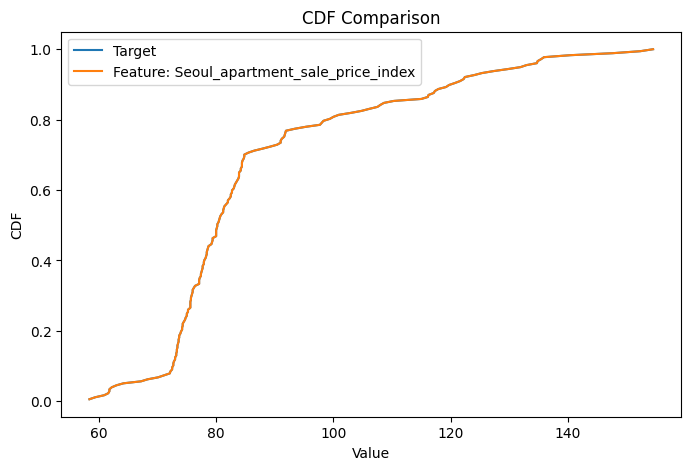

In [199]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import cumfreq

# Target과 Feature의 CDF 비교
def plot_cdf(data, label):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    plt.plot(sorted_data, cdf, label=label)

plt.figure(figsize=(8, 5))

# Target의 CDF
plot_cdf(train_df[nf.columns[0]], label='Target')

# Feature들의 CDF
for feature in columns_to_use:
    plot_cdf(train_df[feature], label=f'Feature: {feature}')

plt.xlabel('Value')
plt.ylabel('CDF')
plt.legend()
plt.title('CDF Comparison')
plt.show()


### NLinear 

In [12]:
class LTSF_NLinear(nn.Module):
    def __init__(self, configs):
        super(LTSF_NLinear, self).__init__()
        self.window_size = configs.seq_len
        self.forcast_size = configs.pred_len
        self.individual = configs.individual
        self.channels = configs.enc_in
        if self.individual:
            self.Linear = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(torch.nn.Linear(self.window_size, self.forcast_size))
        else:
            self.Linear = torch.nn.Linear(self.window_size, self.forcast_size)

    def forward(self, x):
        seq_last = x[:,-1:,:].detach()
        x = x - seq_last
        if self.individual:
            output = torch.zeros([x.size(0), self.forcast_size, x.size(2)],dtype=x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])
            x = output
        else:
            x = self.Linear(x.permute(0,2,1)).permute(0,2,1)
        x = x + seq_last
        return x

### Tools for Prediction

In [10]:
def standardization(train_df, test_df, not_col, target): 
    train_df_ = train_df.copy()
    test_df_ = test_df.copy()
    col =  [col for col in list(train_df.columns) if col not in [not_col]]
    mean_dict = {}
    std_dict = {}
    
    for x in col:
        mean, std = train_df_.agg(["mean", "std"]).loc[:,x]
        train_df_.loc[:, x] = (train_df_[x] - mean) / std
        test_df_.loc[:, x] = (test_df_[x] - mean) / std
        if x in target:
            mean_dict[x] = mean
            std_dict[x] = std
    return train_df_, test_df_, mean_dict, std_dict

def time_slide_df(df, window_size, forecast_size, date, target):
    df_ = df.copy()
    data_list = []
    dap_list = []
    date_list = []
    for idx in range(0, df_.shape[0] - window_size - forecast_size + 1):
        # x: features from the past window_size (including columns)
        x = df_.loc[idx:idx+window_size-1, target].values 
        # get target value for future forecast size 
        y = df_.loc[idx+window_size:idx+window_size+forecast_size-1, target].values
        # get date value for future forecast size 
        date_ = df_.loc[idx+window_size:idx+window_size+forecast_size-1, date].values
        
        data_list.append(x)
        dap_list.append(y)
        date_list.append(date_)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32'), np.array(date_list)

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

### Common Experiment Setting

In [9]:
window_size = 3
forecast_size= 3 

train_df = df[0:177]
test_df = df[177-forecast_size:]
test_df.reset_index(drop=True, inplace=True)
test_df.index.name = "num"

### Train and Save model (Input V1: Variables used in MLP of FA-SEM)
* input: "call_interest_rate", "real_GDP_growth_rate", "residential_building_start_status", f"{target}"
* window_size = 3
* forecast_size= 3 

In [11]:
### Experiment Setting
version = "V1"
batch_size = 16
epoch_ = 500
lr = 0.001
patience = 20  # easrly stopping

columns_to_use = ["call_interest_rate", "real_GDP_growth_rate", "residential_building_start_status"] \
                    + nf.columns.tolist()
configs = Namespace( # Convert configs dictionary to Namespace
    seq_len=max(window_size, 1),  # Set minimum input length to 1
    pred_len=forecast_size,
    individual=False, 
    enc_in= len(columns_to_use) # feature_size
)

In [13]:
# Prepare Dataset
# 정규화된 train_df, test_df와 각 칼럼에 대한 mean_, std_ 딕셔너리가 출력됨. 
train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, date, columns_to_use)
    
train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forecast_size, date, columns_to_use)
test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forecast_size, date, columns_to_use)
    
# Prepare DataLoader 
train_ds = Data(train_x, train_y)
test_ds = Data(test_x, test_y)
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)

# Train the model 
train_loss_list = [] # save the train loss
test_loss_list = [] # save the test loss

# Define the model
model = LTSF_NLinear(configs=configs)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
max_loss = 999999999

patience_counter = 0

100%|██████████| 500/500 [00:06<00:00, 83.16it/s]


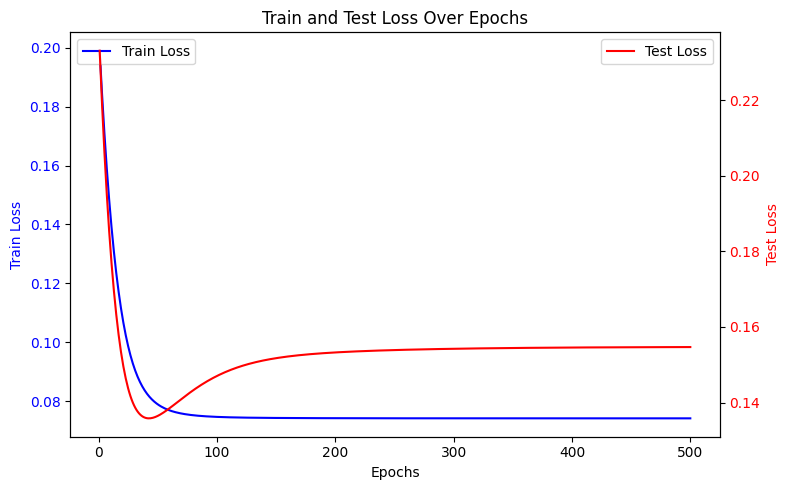

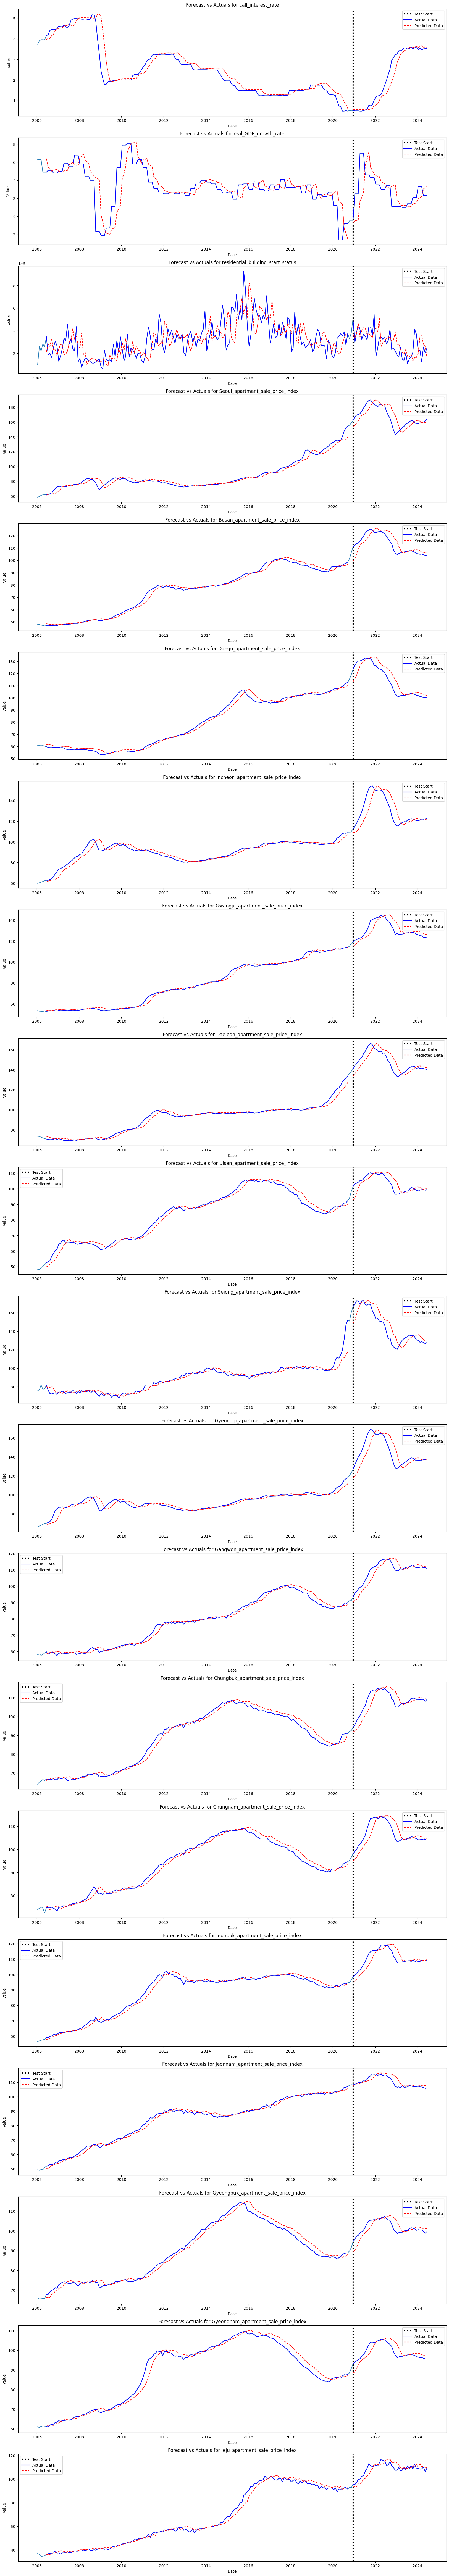

In [14]:
for epoch in tqdm(range(1, epoch_+1)):
    loss_list = []
    model.train()
    train_loss = 0.0 
    for batch_idx, (data, target) in enumerate(train_dl):
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
    train_loss = np.mean(loss_list) 
    train_loss_list.append(train_loss) 

    model.eval()
    with torch.no_grad():
        test_loss_list_epoch = []
        for data, target in test_dl:
            output = model(data)
            test_loss = criterion(output, target)
            test_loss_list_epoch.append(test_loss.item())
            
        test_loss = np.mean(test_loss_list_epoch)
        test_loss_list.append(test_loss)

    if train_loss < max_loss:
        torch.save(model.state_dict(), f"./NLinear{version}.pth")
        max_loss = train_loss
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Model Saved".format(train_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = train_loss
        dlinear_best_test_loss = test_loss
    else:
        patience_counter += 1
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Patience: {}/{}".format(train_loss, test_loss, patience_counter, patience))
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break
    
fig, ax1 = plt.subplots(figsize=(8, 5))
epochs = range(1, len(train_loss_list) + 1)
ax1.plot(epochs, train_loss_list, label='Train Loss', color='b')
ax1.set_xlabel('Epochs')
ax1.set_ylabel("Train Loss",color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc="upper left")
# ax1.grid()
ax2 = ax1.twinx()
ax2.plot(epochs, test_loss_list, label='Test Loss',color='r')
ax2.set_xlabel('Epochs')
ax2.set_ylabel("Test Loss",color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc="upper right") 
# ax2.grid()
plt.title('Train and Test Loss Over Epochs')
fig.tight_layout()
plt.show()
    
# Load model and Evaluate
model.load_state_dict(torch.load(f"./NLinear{version}.pth"))  # 최적 모델 로드
model.eval()

train_dl  = DataLoader(train_ds,  batch_size = len(train_df), shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)
with torch.no_grad():
    for data, target in train_dl:
        train_output = model(data)
        train_predicted = train_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        train_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        train_dates = train_date[:, -1]                    # Dates corresponding to the last forecast
    
    for data, target in test_dl:
        test_output = model(data)
        test_predicted = test_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        test_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        test_dates = test_date[:, -1]  
    
plt.figure(figsize=(20, len(columns_to_use) * 6))  # Adjust the figure size as needed
for i in range(len(columns_to_use)):
    idv_mean = mean_[columns_to_use[i]]
    idv_std = std_[columns_to_use[i]]
    plt.subplot(len(columns_to_use), 1, i + 1)
    plt.plot(df['Date'], df[columns_to_use[i]])
    plt.plot(train_dates, train_actual[:, i]*idv_std+idv_mean, c="b")
    plt.plot(train_dates, train_predicted[:, i]*idv_std+idv_mean, linestyle='--', c="r")
    plt.axvline(x=test_dates[0], color='black', linestyle=':', linewidth=3,label="Test Start")
    plt.plot(test_dates, test_actual[:, i]*idv_std+idv_mean, label='Actual Data', c="b")
    plt.plot(test_dates, test_predicted[:, i]*idv_std+idv_mean, label='Predicted Data', linestyle='--', c="r")
    plt.title(f'Forecast vs Actuals for {columns_to_use[i]}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()        
    real = test_actual[:, i]*idv_std+idv_mean
    pred = test_predicted[:, i]*idv_std+idv_mean
    rmse = mean_squared_error(real, pred)**0.5
    r2 = r2_score(real, pred)
    if columns_to_use[i] in nf.columns:
        val = [columns_to_use[i].split("_")[0], rmse, r2]
        pd.DataFrame(val).T.to_csv(f"./result{version}.csv", mode='a', header=False, index=False)
    

### Train and Save model (Input V2: All variables used in FA-SEM-MLP)
* input: "call_interest_rate", "government_bond_3yr", "deposit_bank_loan_rate_avg", "KOSPI_index", "KOSDAQ_index", "NASDAQ_index", "M2_Korea", "M2_USA", "broad_liquidity", "CPI_growth_rate", "USD_KRW_exchange_rate", "real_GDP_growth_rate", "residential_building_start_status", "residential_building_permit_status", "construction_production_index_seasonally_adjusted", 
f"{target}"
* window_size = 3
* forecast_size= 3 

In [15]:
### Experiment Setting
version = "V2"
### Experiment Setting
batch_size = 16
kernel_size = 25
epoch_ = 500
lr = 0.001
patience = 20  # easrly stopping

columns_to_use = column + nf.columns.tolist()
configs = Namespace( # Convert configs dictionary to Namespace
    seq_len=max(window_size, 1),  # Set minimum input length to 1
    pred_len=forecast_size,
    individual=False, 
    enc_in= len(columns_to_use) # feature_size
)

In [16]:
# Prepare Dataset
# 정규화된 train_df, test_df와 각 칼럼에 대한 mean_, std_ 딕셔너리가 출력됨. 
train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, date, columns_to_use)
    
train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forecast_size, date, columns_to_use)
test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forecast_size, date, columns_to_use)
    
# Prepare DataLoader 
train_ds = Data(train_x, train_y)
test_ds = Data(test_x, test_y)
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)

# Train the model 
train_loss_list = [] # save the train loss
test_loss_list = [] # save the test loss

# Define the model
model = LTSF_NLinear(configs=configs)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
max_loss = 999999999

patience_counter = 0

  0%|          | 0/500 [00:00<?, ?it/s]

 57%|█████▋    | 283/500 [00:03<00:02, 87.12it/s]


Early stopping triggered.


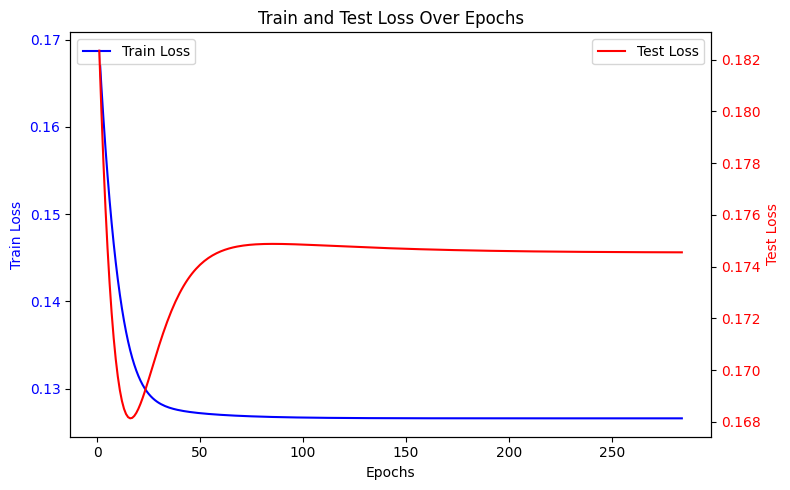

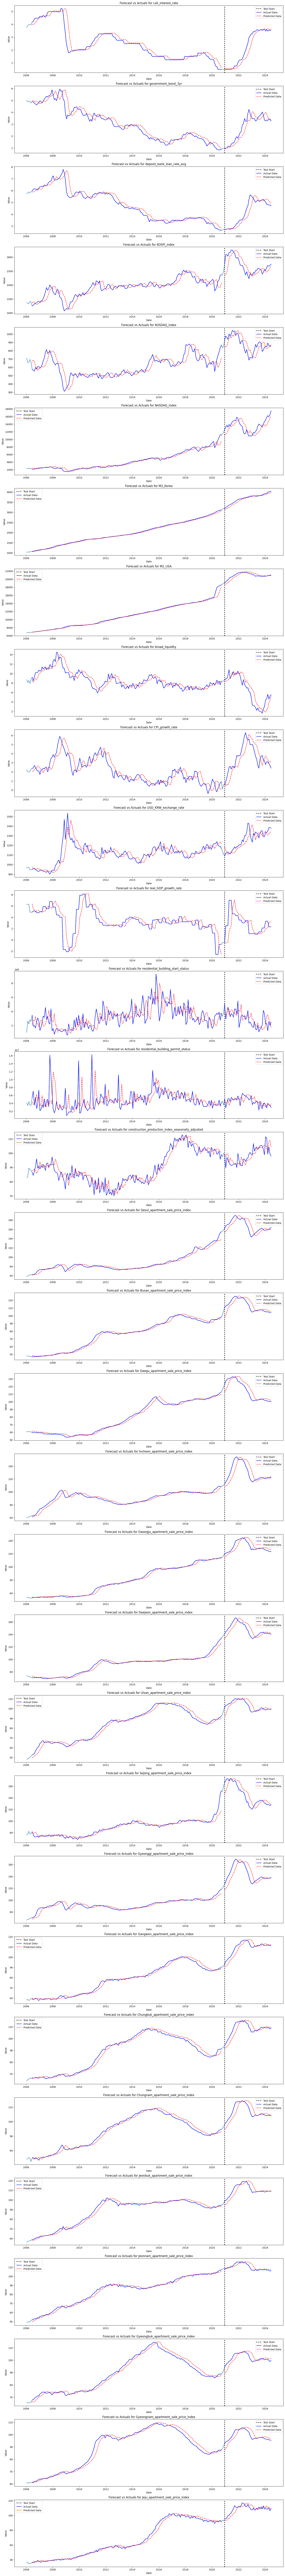

In [17]:
for epoch in tqdm(range(1, epoch_+1)):
    loss_list = []
    model.train()
    train_loss = 0.0 
    for batch_idx, (data, target) in enumerate(train_dl):
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
    train_loss = np.mean(loss_list) 
    train_loss_list.append(train_loss) 

    model.eval()
    with torch.no_grad():
        test_loss_list_epoch = []
        for data, target in test_dl:
            output = model(data)
            test_loss = criterion(output, target)
            test_loss_list_epoch.append(test_loss.item())
            
        test_loss = np.mean(test_loss_list_epoch)
        test_loss_list.append(test_loss)

    if train_loss < max_loss:
        torch.save(model.state_dict(), f"./NLinear{version}.pth")
        max_loss = train_loss
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Model Saved".format(train_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = train_loss
        dlinear_best_test_loss = test_loss
    else:
        patience_counter += 1
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Patience: {}/{}".format(train_loss, test_loss, patience_counter, patience))
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break
    
fig, ax1 = plt.subplots(figsize=(8, 5))
epochs = range(1, len(train_loss_list) + 1)
ax1.plot(epochs, train_loss_list, label='Train Loss', color='b')
ax1.set_xlabel('Epochs')
ax1.set_ylabel("Train Loss",color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc="upper left")
# ax1.grid()
ax2 = ax1.twinx()
ax2.plot(epochs, test_loss_list, label='Test Loss',color='r')
ax2.set_xlabel('Epochs')
ax2.set_ylabel("Test Loss",color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc="upper right") 
# ax2.grid()
plt.title('Train and Test Loss Over Epochs')
fig.tight_layout()
plt.show()
    
# Load model and Evaluate
model.load_state_dict(torch.load(f"./NLinear{version}.pth"))  # 최적 모델 로드
model.eval()

train_dl  = DataLoader(train_ds,  batch_size = len(train_df), shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)
with torch.no_grad():
    for data, target in train_dl:
        train_output = model(data)
        train_predicted = train_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        train_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        train_dates = train_date[:, -1]                    # Dates corresponding to the last forecast
    
    for data, target in test_dl:
        test_output = model(data)
        test_predicted = test_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        test_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        test_dates = test_date[:, -1]  
    
plt.figure(figsize=(20, len(columns_to_use) * 6))  # Adjust the figure size as needed
for i in range(len(columns_to_use)):
    idv_mean = mean_[columns_to_use[i]]
    idv_std = std_[columns_to_use[i]]
    plt.subplot(len(columns_to_use), 1, i + 1)
    plt.plot(df['Date'], df[columns_to_use[i]])
    plt.plot(train_dates, train_actual[:, i]*idv_std+idv_mean, c="b")
    plt.plot(train_dates, train_predicted[:, i]*idv_std+idv_mean, linestyle='--', c="r")
    plt.axvline(x=test_dates[0], color='black', linestyle=':', linewidth=3,label="Test Start")
    plt.plot(test_dates, test_actual[:, i]*idv_std+idv_mean, label='Actual Data', c="b")
    plt.plot(test_dates, test_predicted[:, i]*idv_std+idv_mean, label='Predicted Data', linestyle='--', c="r")
    plt.title(f'Forecast vs Actuals for {columns_to_use[i]}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()        
    real = test_actual[:, i]*idv_std+idv_mean
    pred = test_predicted[:, i]*idv_std+idv_mean
    rmse = mean_squared_error(real, pred)**0.5
    r2 = r2_score(real, pred)
    if columns_to_use[i] in nf.columns:
        val = [columns_to_use[i].split("_")[0], rmse, r2]
        pd.DataFrame(val).T.to_csv(f"./result{version}.csv", mode='a', header=False, index=False)
    

### Train and Save model (Input V3: Just using Past target)
* input: f"{target}"
* window_size = 3
* forecast_size= 3 

In [18]:
### Experiment Setting
version = "V3"
window_size = 3
forecast_size= 3 
epoch_ = 500
lr = 0.001
patience = 20  # early stopping

columns_to_use = nf.columns.tolist()
configs = Namespace( # Convert configs dictionary to Namespace
    seq_len=max(window_size, 1),  # Set minimum input length to 1
    pred_len=forecast_size,
    individual=False, 
    enc_in= len(columns_to_use) # feature_size
)

In [19]:
# Prepare Dataset
train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, date, columns_to_use)
    
train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forecast_size, date, columns_to_use)
test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forecast_size, date, columns_to_use)
    
# Prepare DataLoader 
train_ds = Data(train_x, train_y)
test_ds = Data(test_x, test_y)
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)

# Train the model 
train_loss_list = [] # save the train loss
test_loss_list = [] # save the test loss

# Define the model
model = LTSF_NLinear(configs=configs)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
max_loss = 999999999

patience_counter = 0

100%|██████████| 500/500 [00:05<00:00, 89.37it/s]


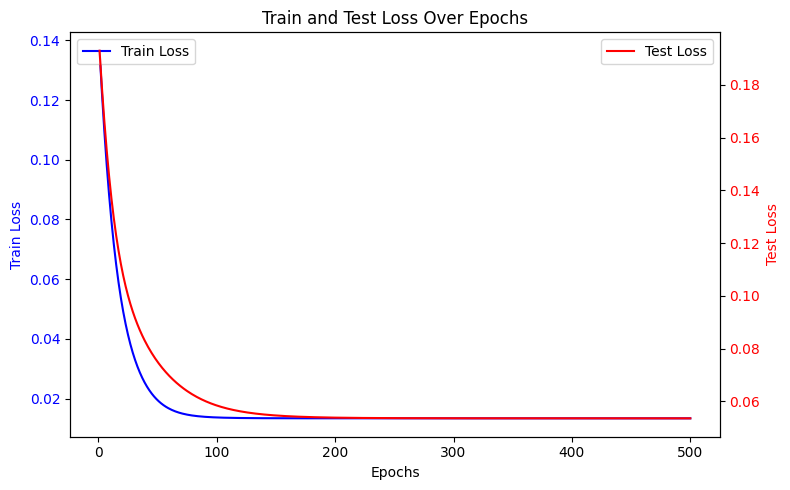

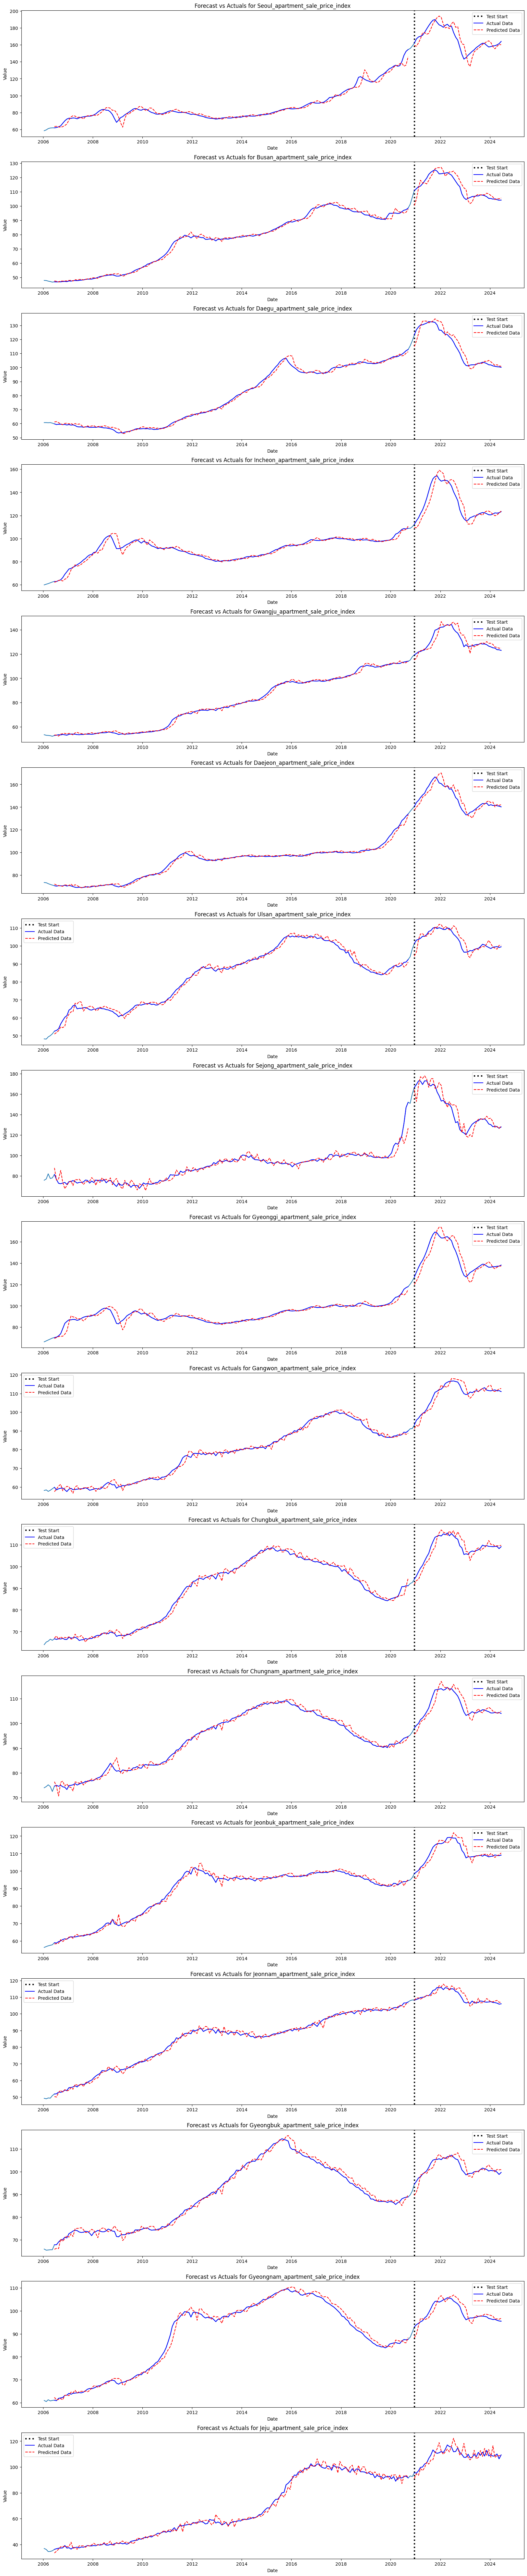

In [20]:
for epoch in tqdm(range(1, epoch_+1)):
    loss_list = []
    model.train()
    train_loss = 0.0 
    for batch_idx, (data, target) in enumerate(train_dl):
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
    train_loss = np.mean(loss_list) 
    train_loss_list.append(train_loss) 

    model.eval()
    with torch.no_grad():
        test_loss_list_epoch = []
        for data, target in test_dl:
            output = model(data)
            test_loss = criterion(output, target)
            test_loss_list_epoch.append(test_loss.item())
            
        test_loss = np.mean(test_loss_list_epoch)
        test_loss_list.append(test_loss)

    if train_loss < max_loss:
        torch.save(model.state_dict(), f"./NLinear{version}.pth")
        max_loss = train_loss
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Model Saved".format(train_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = train_loss
        dlinear_best_test_loss = test_loss
    else:
        patience_counter += 1
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Patience: {}/{}".format(train_loss, test_loss, patience_counter, patience))
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break
    
fig, ax1 = plt.subplots(figsize=(8, 5))
epochs = range(1, len(train_loss_list) + 1)
ax1.plot(epochs, train_loss_list, label='Train Loss', color='b')
ax1.set_xlabel('Epochs')
ax1.set_ylabel("Train Loss",color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc="upper left")
# ax1.grid()
ax2 = ax1.twinx()
ax2.plot(epochs, test_loss_list, label='Test Loss',color='r')
ax2.set_xlabel('Epochs')
ax2.set_ylabel("Test Loss",color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc="upper right") 
# ax2.grid()
plt.title('Train and Test Loss Over Epochs')
fig.tight_layout()
plt.show()
    
# Load model and Evaluate
model.load_state_dict(torch.load(f"./NLinear{version}.pth"))  # 최적 모델 로드
model.eval()

train_dl  = DataLoader(train_ds,  batch_size = len(train_df), shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)
with torch.no_grad():
    for data, target in train_dl:
        train_output = model(data)
        train_predicted = train_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        train_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        train_dates = train_date[:, -1]                    # Dates corresponding to the last forecast
    
    for data, target in test_dl:
        test_output = model(data)
        test_predicted = test_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        test_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        test_dates = test_date[:, -1]  
    
plt.figure(figsize=(20, len(columns_to_use) * 6))  # Adjust the figure size as needed
for i in range(len(columns_to_use)):
    idv_mean = mean_[columns_to_use[i]]
    idv_std = std_[columns_to_use[i]]
    plt.subplot(len(columns_to_use), 1, i + 1)
    plt.plot(df['Date'], df[columns_to_use[i]])
    plt.plot(train_dates, train_actual[:, i]*idv_std+idv_mean, c="b")
    plt.plot(train_dates, train_predicted[:, i]*idv_std+idv_mean, linestyle='--', c="r")
    plt.axvline(x=test_dates[0], color='black', linestyle=':', linewidth=3,label="Test Start")
    plt.plot(test_dates, test_actual[:, i]*idv_std+idv_mean, label='Actual Data', c="b")
    plt.plot(test_dates, test_predicted[:, i]*idv_std+idv_mean, label='Predicted Data', linestyle='--', c="r")
    plt.title(f'Forecast vs Actuals for {columns_to_use[i]}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()        
    real = test_actual[:, i]*idv_std+idv_mean
    pred = test_predicted[:, i]*idv_std+idv_mean
    rmse = mean_squared_error(real, pred)**0.5
    r2 = r2_score(real, pred)
    if columns_to_use[i] in nf.columns:
        val = [columns_to_use[i].split("_")[0], rmse, r2]
        pd.DataFrame(val).T.to_csv(f"./result{version}.csv", mode='a', header=False, index=False)
    

### Individual = True

In [21]:
### Experiment Setting
version = "V_idv"
window_size = 3
forecast_size= 3 
epoch_ = 500
lr = 0.001
patience = 20  # early stopping

columns_to_use = nf.columns.tolist()
configs = Namespace( # Convert configs dictionary to Namespace
    seq_len=max(window_size, 1),  # Set minimum input length to 1
    pred_len=forecast_size,
    individual=True, 
    enc_in= len(columns_to_use) # feature_size
)

In [22]:
# Prepare Dataset
train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, date, columns_to_use)
    
train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forecast_size, date, columns_to_use)
test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forecast_size, date, columns_to_use)
    
# Prepare DataLoader 
train_ds = Data(train_x, train_y)
test_ds = Data(test_x, test_y)
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)

# Train the model 
train_loss_list = [] # save the train loss
test_loss_list = [] # save the test loss

# Define the model
model = LTSF_NLinear(configs=configs)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
max_loss = 999999999

patience_counter = 0

100%|██████████| 500/500 [00:34<00:00, 14.41it/s]


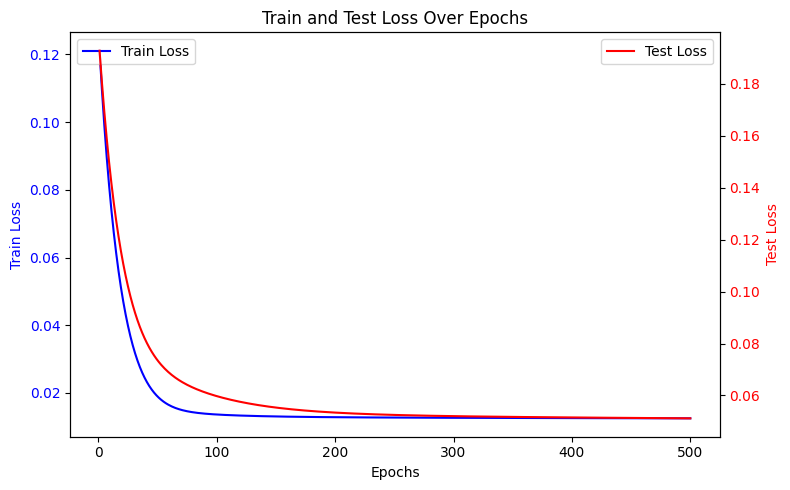

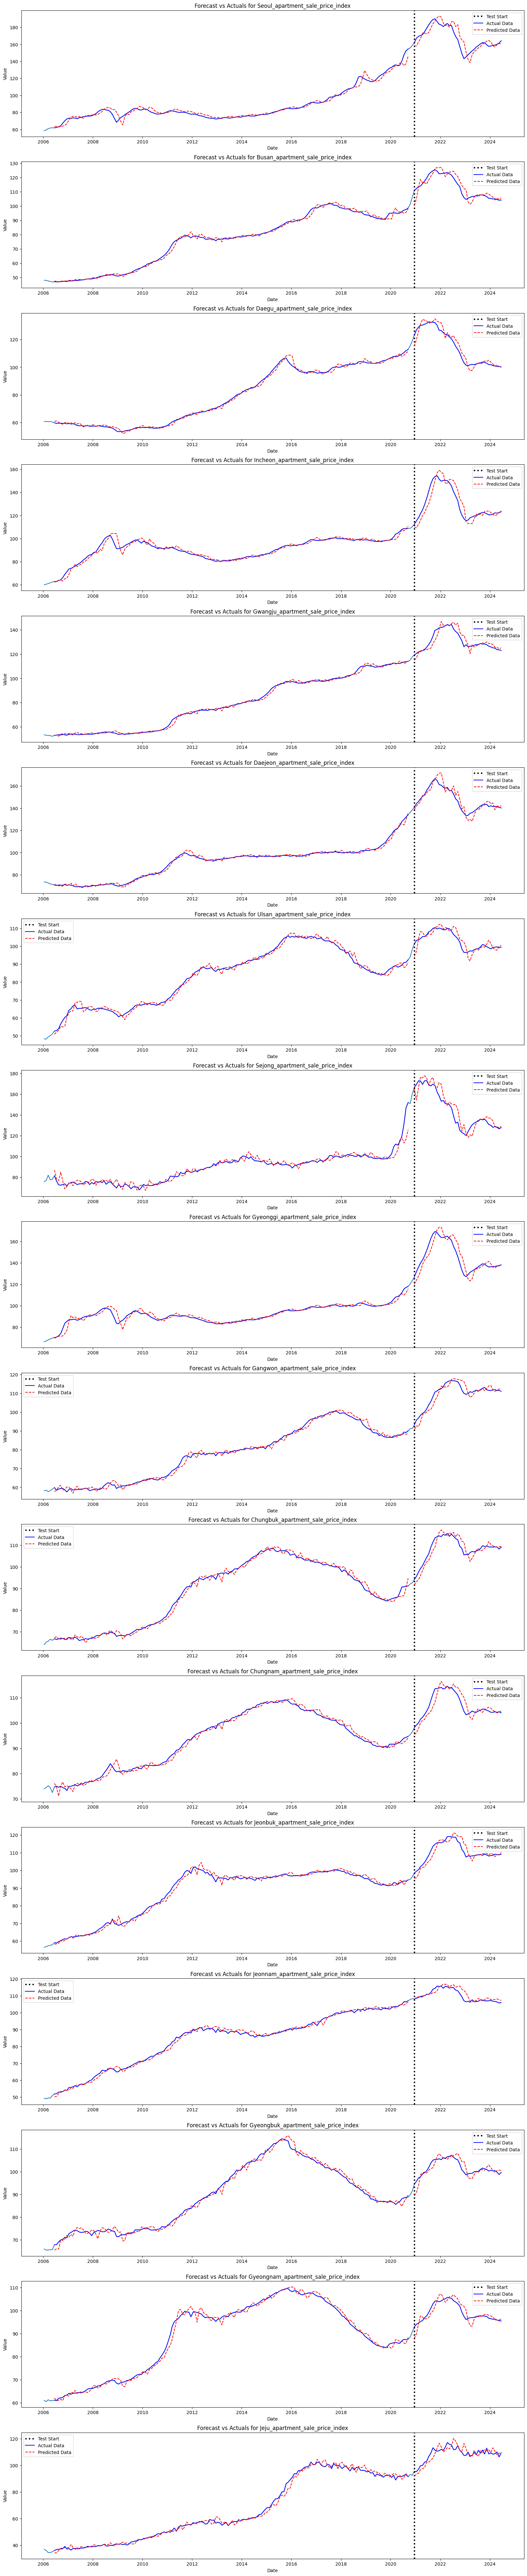

In [23]:
for epoch in tqdm(range(1, epoch_+1)):
    loss_list = []
    model.train()
    train_loss = 0.0 
    for batch_idx, (data, target) in enumerate(train_dl):
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
    train_loss = np.mean(loss_list) 
    train_loss_list.append(train_loss) 

    model.eval()
    with torch.no_grad():
        test_loss_list_epoch = []
        for data, target in test_dl:
            output = model(data)
            test_loss = criterion(output, target)
            test_loss_list_epoch.append(test_loss.item())
            
        test_loss = np.mean(test_loss_list_epoch)
        test_loss_list.append(test_loss)

    if train_loss < max_loss:
        torch.save(model.state_dict(), f"./NLinear{version}.pth")
        max_loss = train_loss
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Model Saved".format(train_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = train_loss
        dlinear_best_test_loss = test_loss
    else:
        patience_counter += 1
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Patience: {}/{}".format(train_loss, test_loss, patience_counter, patience))
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break
    
fig, ax1 = plt.subplots(figsize=(8, 5))
epochs = range(1, len(train_loss_list) + 1)
ax1.plot(epochs, train_loss_list, label='Train Loss', color='b')
ax1.set_xlabel('Epochs')
ax1.set_ylabel("Train Loss",color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc="upper left")
# ax1.grid()
ax2 = ax1.twinx()
ax2.plot(epochs, test_loss_list, label='Test Loss',color='r')
ax2.set_xlabel('Epochs')
ax2.set_ylabel("Test Loss",color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc="upper right") 
# ax2.grid()
plt.title('Train and Test Loss Over Epochs')
fig.tight_layout()
plt.show()
    
# Load model and Evaluate
model.load_state_dict(torch.load(f"./NLinear{version}.pth"))  # 최적 모델 로드
model.eval()

train_dl  = DataLoader(train_ds,  batch_size = len(train_df), shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)
with torch.no_grad():
    for data, target in train_dl:
        train_output = model(data)
        train_predicted = train_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        train_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        train_dates = train_date[:, -1]                    # Dates corresponding to the last forecast
    
    for data, target in test_dl:
        test_output = model(data)
        test_predicted = test_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        test_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        test_dates = test_date[:, -1]  
    
plt.figure(figsize=(20, len(columns_to_use) * 6))  # Adjust the figure size as needed
for i in range(len(columns_to_use)):
    idv_mean = mean_[columns_to_use[i]]
    idv_std = std_[columns_to_use[i]]
    plt.subplot(len(columns_to_use), 1, i + 1)
    plt.plot(df['Date'], df[columns_to_use[i]])
    plt.plot(train_dates, train_actual[:, i]*idv_std+idv_mean, c="b")
    plt.plot(train_dates, train_predicted[:, i]*idv_std+idv_mean, linestyle='--', c="r")
    plt.axvline(x=test_dates[0], color='black', linestyle=':', linewidth=3,label="Test Start")
    plt.plot(test_dates, test_actual[:, i]*idv_std+idv_mean, label='Actual Data', c="b")
    plt.plot(test_dates, test_predicted[:, i]*idv_std+idv_mean, label='Predicted Data', linestyle='--', c="r")
    plt.title(f'Forecast vs Actuals for {columns_to_use[i]}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()        
    real = test_actual[:, i]*idv_std+idv_mean
    pred = test_predicted[:, i]*idv_std+idv_mean
    rmse = mean_squared_error(real, pred)**0.5
    r2 = r2_score(real, pred)
    if columns_to_use[i] in nf.columns:
        val = [columns_to_use[i].split("_")[0], rmse, r2]
        pd.DataFrame(val).T.to_csv(f"./result{version}.csv", mode='a', header=False, index=False)
    